In [5]:
load_ext cython

In [20]:
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.io import loadmat
import sys
from math import exp, sqrt, pi
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

#parameters
time_len = 1000
activations_len = 5
gaussian_variance = 100

#datasets
activations = None
gaussian_array = None
covariances = None
# @profile
def correlation_calculation_single(filename):

    data = np.load(filename)
    true_covariances = data['arr_0']
    true_covariances1 = data['arr_1']
    activations = data['arr_2']
    activations_len, time_len = activations.shape
    gaussian_array = np.array([exp(-timepoint**2/2/gaussian_variance)/sqrt(2*pi*gaussian_variance) for timepoint in range(-time_len+1,time_len)])
    covariances = covariance_fragments = np.zeros([time_len, activations_len, activations_len])
    covariances_vector = np.zeros([time_len,(activations_len * (activations_len-1) / 2)])
    activations_shifted = activations - np.concatenate((np.zeros([activations_len,1]),activations[:,:-1]),1)

    for timepoint in range(1,time_len-1):
        covariance_fragments[timepoint,:,:] = np.cov(activations_shifted[:,(timepoint-1):(timepoint+2)])
    covariance_fragments[0,:,:], covariance_fragments[time_len-1,:,:] = covariance_fragments[1,:,:], covariance_fragments[time_len-2,:,:]


    for timepoint in range(time_len):
        coefficients = gaussian_array[(time_len-1-timepoint):(2*time_len-1-timepoint)]
        coefficients = coefficients/np.sum(coefficients)
        coefficients = np.array([np.tile(val,[activations_len,activations_len]) for val in coefficients])
        covariances[timepoint,:,:] = np.sum(np.multiply(coefficients, covariance_fragments),0)

    # covariances = np.mean(0.5*(np.log(1+covariances) - np.log(1-covariances)),0)/2
    # covariances =  (np.exp(2*covariances) - 1)/(np.exp(2*covariances) + 1)

    for i in range(time_len):
        covariances_vector[i] = squareform(covariances[i,:,:],checks=False)



    true_covariances_vector = squareform(true_covariances,checks=False)
    true_covariances_vector1 = squareform(true_covariances1,checks=False)
    Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
    Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
#     plt.plot(range(time_len),Y,'b-')
#     plt.plot(range(time_len),Y1,'r-')
#     plt.show()

# @profile
def correlation_calculation_multiple(filename):
    #parameter initialization
    data = np.load(filename)
    true_covariances = data['arr_0']
    true_covariances1 = data['arr_1']
    data = data['arr_2']
    
    subj_num = data.size
    time_len, activations_len = data[0].shape
    covariances = covariance_fragments = np.zeros([subj_num,time_len,activations_len,activations_len])
    gaussian_array = np.array([exp(-timepoint**2/2/gaussian_variance)/sqrt(2*pi*gaussian_variance) for timepoint in range(-time_len+1,time_len)])
    covariances_vector = np.zeros([time_len,(activations_len * (activations_len-1) / 2)])
    coefficients = np.zeros([time_len,time_len,activations_len,activations_len])

    for timepoint in range(time_len):
        coefficient = gaussian_array[(time_len-1-timepoint):(2*time_len-1-timepoint)]
        coefficient = coefficient/np.sum(coefficient)
        coefficients[timepoint] = np.array([np.tile(val,[activations_len,activations_len]) for val in coefficient])

    for subject,subject_data in enumerate(data):
        activations[subject] = subject_data.T
    activations_shifted = activations - np.concatenate((np.zeros([subj_num,activations_len,1]),activations[:,:,:-1]),2)
    activations_sum = (np.tile(np.sum(activations_shifted,0),[subj_num,1,1]) - activations_shifted)/(subj_num-1)

    for subj in range(subj_num):
        for timepoint in range(1,time_len-1):
            covariance_fragments[subj,timepoint,:,:] = np.cov(activations_shifted[subj,:,(timepoint-1):(timepoint+2)],\
                                                            activations_sum[subj,:,(timepoint-1):(timepoint+2)])[:activations_len,activations_len:]
        covariance_fragments[subj,0,:,:], covariance_fragments[subj,time_len-1,:,:] = covariance_fragments[subj,1,:,:], covariance_fragments[subj,time_len-2,:,:]

        for timepoint in range(time_len):
            covariances[subj, timepoint,:,:] = np.sum(np.multiply(coefficients[timepoint], covariance_fragments[subj]),0)

    covariances = np.mean(0.5*(np.log(1+covariances) - np.log(1-covariances)),0)/2
    covariances =  (np.exp(2*covariances) - 1)/(np.exp(2*covariances) + 1)

    for i in range(time_len):
        covariances_vector[i] = squareform(covariances[i,:,:],checks=False)

    Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
    Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
    plt.plot(range(time_len),Y,'b-')
    plt.plot(range(time_len),Y1,'r-')
    plt.show()
    # return result

# if __name__ == "__main__":
#     filename = sys.argv[1]
#     if len(sys.argv)>2 and sys.argv[2]=="single":
#         print("single:")
#         correlation_calculation_single(filename)
#     else:
#         correlation_calculation_multiple(filename)
#temp
# print("True covariance:")
# print(true_covariances)
#
# print("True covariance1:")
# print(true_covariances1)

# print("Overall covariances:")
# print(np.cov(activations_shifted))
# print("Mean covariance:")
# print(np.mean(covariances,0))
#
# print("Calculated Covariance:")
# print(covariances)

# Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
# Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
# plt.plot(range(time_len),Y,'b-')
# plt.plot(range(time_len),Y1,'r-')
# plt.show()


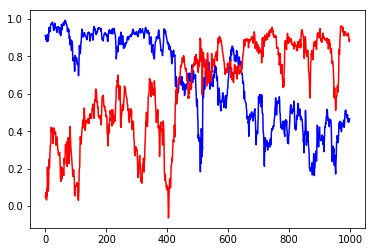

In [33]:
correlation_calculation_single("../synthetic_data_cross.npz", 100)

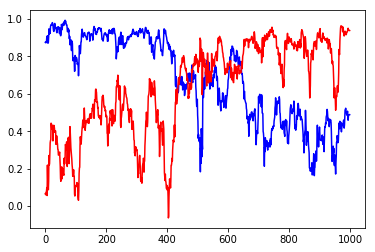

In [30]:
correlation_calculation_single("../synthetic_data_cross.npz", 100, 11)

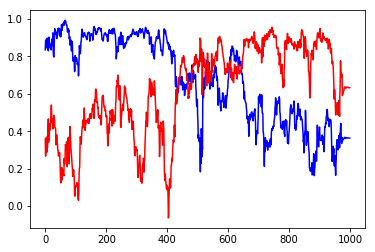

In [31]:
correlation_calculation_single("../synthetic_data_cross.npz", 100, 51)

In [32]:
%%cython

import numpy as np
cimport numpy as np
from scipy.stats.stats import pearsonr
from scipy.io import loadmat
import sys
from math import exp, sqrt, pi
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

def timecorr_input(filename, gaussian_variance, estimation_range=3, mode = "within")
    data = np.load(filename)
    activations = data['arr_2'].T
    
def timecorr(activations, gaussian_variance, estimation_range=3, mode = "within"):
    
    if len(activations.shape)==0:
        return correlation_calculation_single(activations.T, gaussian_variance, estimation_range)
    else:
        #the data file is expected to be of dimensions [subject number, time lenghth, activations length]
        subject_num = len(activations)
        activations_len, time_len= subject_weights[0].shape
        if mode=="within":
            subject_num = len(activations)
            activations_len, time_len= activations[0].shape
            result = np.zeros([subject_num, time_len,(activations_len * (activations_len-1) / 2)])
            for subject in range(subject_num):
                result[subject] = correlation_calculation_single(activations[subject].T, gaussian_variance, estimation_range)
        else:
            return ISFC(activations, gaussian_variance, estimation_range)
    
    
def correlation_calculation_single(np.ndarray activations, int gaussian_variance, int estimation_range):
    cdef np.ndarray activations, gaussian_array, covariances, covariances_vector
    cdef np.ndarray activations_shifted, covariance_fragments
    cdef int timepoint, i, half_range
    
    half_range = int((estimation_range-1)/2)
    activations_len, time_len = activations.shape[0], activations.shape[1]
    gaussian_array = np.array([exp(-timepoint**2/2/gaussian_variance)/sqrt(2*pi*gaussian_variance) for timepoint in range(-time_len+1,time_len)])
    covariances = covariance_fragments = np.zeros([time_len, activations_len, activations_len])
    covariances_vector = np.zeros([time_len,(activations_len * (activations_len-1) / 2)])
    activations_shifted = activations - np.concatenate((np.zeros([activations_len,1]),activations[:,:-1]),1)

    for timepoint in range(half_range,time_len-half_range):
        covariance_fragments[timepoint,:,:] = np.cov(activations_shifted[:,(timepoint-1):(timepoint+2)])        
    covariance_fragments[range(half_range),:,:], covariance_fragments[range(time_len-half_range, time_len),:,:] = covariance_fragments[1,:,:], covariance_fragments[time_len-2,:,:]


    for timepoint in range(time_len):
        coefficients = gaussian_array[(time_len-1-timepoint):(2*time_len-1-timepoint)]
        coefficients = coefficients/np.sum(coefficients)
        coefficients = np.array([np.tile(val,[activations_len,activations_len]) for val in coefficients])
        covariances[timepoint,:,:] = np.sum(np.multiply(coefficients, covariance_fragments),0)

    for i in range(time_len):
        covariances_vector[i] = squareform(covariances[i,:,:],checks=False)

    true_covariances_vector = squareform(true_covariances,checks=False)
    true_covariances_vector1 = squareform(true_covariances1,checks=False)
    Y = np.array([pearsonr(covariances_vector[i,],true_covariances_vector)[0] for i in range(time_len)])
    Y1 = np.array([pearsonr(covariances_vector[i,],true_covariances_vector1)[0] for i in range(time_len)])
    plt.plot(range(time_len),Y,'b-')
    plt.plot(range(time_len),Y1,'r-')
    plt.show()

    
    
def ISFC(np.ndarray[double, ndim=3] activations, int gaussian_variance, int estimation_range):
    #cython variable declaration
    cdef int time_len, activations_len, subj_num, timepoint, gaussian_variance, subject
    cdef double val
    cdef np.ndarray[double, ndim=2] covariances_vector
    cdef np.ndarray[double, ndim=3] activations_shifted, activations_sum, covariances_mean
    cdef np.ndarray[double, ndim=4] covariances, covariance_fragments
    cdef np.ndarray gaussian_array,

    #assign initial parameters
    gaussian_variance = 100
    subj_num = activations.shape[0]
    activations_len, time_len= activations[0].shape
    covariances = covariance_fragments = np.zeros([subj_num,time_len,activations_len,activations_len])
    covariances_vector = np.zeros([time_len,(activations_len * (activations_len-1) / 2)])
    gaussian_array = np.array([exp(-timepoint**2/2/gaussian_variance)/sqrt(2*pi*gaussian_variance) for timepoint in range(-time_len+1,time_len)])

    #generate the activation matrix by finding difference between consecutive datapoints
    activations_shifted = activations - np.concatenate((np.zeros([subj_num,activations_len,1]),activations[:,:,:-1]),2)

    #create a matrix that, for each subject, contains the sum of the data for all other subjects
    activations_sum = (np.tile(np.sum(activations_shifted,0),[subj_num,1,1]) - activations_shifted)/(subj_num-1)

    #calculate the covariances for each timepoint for each subject
    for subj in range(subj_num):
        #calculate covariance fragments for each timepoint using 3 consecutive timepoints
        for timepoint in range(1,time_len-1):
            covariance_fragments[subj,timepoint,:,:] = np.cov(activations_shifted[subj,:,(timepoint-1):(timepoint+2)],\
                                                            activations_sum[subj,:,(timepoint-1):(timepoint+2)])[:activations_len,activations_len:]

        #the first and last timepoint of the covariance fragments are equal to the second and second to last fragments
        covariance_fragments[subj,0,:,:], covariance_fragments[subj,time_len-1,:,:] = covariance_fragments[subj,1,:,:], covariance_fragments[subj,time_len-2,:,:]

        #multiply the covariance fragments with the gaussian coefficients
        for timepoint in range(time_len):
            covariances[subj, timepoint,:,:] = np.sum(np.multiply(coefficients[timepoint], covariance_fragments[subj]),0)

    #normalize and average the covariance matrix
    covariances_mean = np.mean(0.5*(np.log(1+covariances) - np.log(1-covariances)),0)/2
    covariances_mean =  (np.exp(2*covariances_mean) - 1)/(np.exp(2*covariances_mean) + 1)

    #convert the square covariance matrices into vector form
    for i in range(time_len):
        covariances_vector[i] = squareform(covariances_mean[i,:,:],checks=False)

    return covariances_vector

In [ ]:
import sys
import h5py
import numpy as np
cimport numpy as np
from scipy.io import loadmat
from random import shuffle
import matplotlib.pyplot as plt
from math import exp, sqrt, pi
from scipy.spatial.distance import squareform

def covariance_calculation(np.ndarray[double,ndim=4] coefficients, np.ndarray[double, ndim=3] activations):
    #cython variable declaration
    cdef int time_len, activations_len, subj_num, timepoint, gaussian_variance, subject
    cdef double val
    cdef np.ndarray[double, ndim=2] covariances_vector
    cdef np.ndarray[double, ndim=3] activations_shifted, activations_sum, covariances_mean
    cdef np.ndarray[double, ndim=4] covariances, covariance_fragments
    cdef np.ndarray gaussian_array,

    #assign initial parameters
    gaussian_variance = 100
    subj_num = activations.shape[0]
    activations_len, time_len= activations[0].shape
    covariances = covariance_fragments = np.zeros([subj_num,time_len,activations_len,activations_len])
    covariances_vector = np.zeros([time_len,(activations_len * (activations_len-1) / 2)])

    #generate the activation matrix by finding difference between consecutive datapoints
    activations_shifted = activations - np.concatenate((np.zeros([subj_num,activations_len,1]),activations[:,:,:-1]),2)

    #create a matrix that, for each subject, contains the sum of the data for all other subjects
    activations_sum = (np.tile(np.sum(activations_shifted,0),[subj_num,1,1]) - activations_shifted)/(subj_num-1)

    #calculate the covariances for each timepoint for each subject
    for subj in range(subj_num):
        #calculate covariance fragments for each timepoint using 3 consecutive timepoints
        for timepoint in range(1,time_len-1):
            covariance_fragments[subj,timepoint,:,:] = np.cov(activations_shifted[subj,:,(timepoint-1):(timepoint+2)],\
                                                            activations_sum[subj,:,(timepoint-1):(timepoint+2)])[:activations_len,activations_len:]

        #the first and last timepoint of the covariance fragments are equal to the second and second to last fragments
        covariance_fragments[subj,0,:,:], covariance_fragments[subj,time_len-1,:,:] = covariance_fragments[subj,1,:,:], covariance_fragments[subj,time_len-2,:,:]

        #multiply the covariance fragments with the gaussian coefficients
        for timepoint in range(time_len):
            covariances[subj, timepoint,:,:] = np.sum(np.multiply(coefficients[timepoint], covariance_fragments[subj]),0)

    #normalize and average the covariance matrix
    covariances_mean = np.mean(0.5*(np.log(1+covariances) - np.log(1-covariances)),0)/2
    covariances_mean =  (np.exp(2*covariances_mean) - 1)/(np.exp(2*covariances_mean) + 1)

    #convert the square covariance matrices into vector form
    for i in range(time_len):
        covariances_vector[i] = squareform(covariances_mean[i,:,:],checks=False)

    return covariances_vector

def decoding_analysis(filename):
    cdef int time_len, activations_len, subj_num, timepoint, gaussian_variance, subject, tests
    cdef double accuracy
    cdef np.ndarray[double,ndim=2] covariance1, covariance2, correlation, correlation1, correlation2
    cdef np.ndarray[double,ndim=3] activations
    cdef np.ndarray[double,ndim=4] coefficients
    accuracy_list = np.zeros([1,100])

    #load in data
    data_dict = loadmat(filename, squeeze_me=True)
    subject_weights  = data_dict['weights']

    subj_num = subject_weights.size
    time_len, activations_len= subject_weights[0].shape

    subj_indices = np.arange(subj_num)

    #generate activations from subject weights
    activations = np.zeros([subj_num, activations_len, time_len])
    for subject, subject_data in enumerate(subject_weights):
        activations[subject] = subject_data.T

    #load in gaussian coefficients
    f = h5py.File("coefficients.hdf5", "r")
    coefficients = f['coefficients'][:]

    for tests in range(1):
        shuffle(subj_indices)
        covariance1 = covariance_calculation(coefficients, activations[subj_indices[:(subj_num/2)],:,:]).T
        covariance2 = covariance_calculation(coefficients, activations[subj_indices[(subj_num/2):],:,:]).T
        correlation = np.corrcoef(covariance1, covariance1)
        correlation1 = correlation[:time_len,time_len:]
        correlation2 = correlation[time_len:,:time_len]
        accuracy = 0.0
        for timepoint in range(time_len):
            if np.argmax(correlation1[timepoint])==timepoint:
                accuracy+=1
            if np.argmax(correlation2[timepoint])==timepoint:
                accuracy+=1
        accuracy_list[0,tests]=accuracy/(time_len*2)

    print accuracy_list
    print(np.mean(accuracy_list))

    f.close()